# Train EVI Forecast

### System Imports

In [1]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import pickle

### Local Imports

In [2]:
from utils.config import farmbeats_config
from utils.weather_util import WeatherUtil
from utils.satellite_util import SatelliteUtil
from utils.constants import CONSTANTS
from utils.ard_util import ard_preprocess

### Packages for Model

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)
tf.test.gpu_device_name()

''

In [42]:
sat_links = pd.read_csv(CONSTANTS["sat_file_paths"])

In [43]:
sat_links

,fileLink,name,resolution,id,sceneDateTime,boundaryId,cloudCoverPercentage,darkPixelPercentage,boundary_count,filePath
0,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,ddf184b9-c05a-987f-7d6c-23ba20cf3cd6,2019-07-15T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...
1,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,d26ffee7-02e5-b063-f230-0a4846a14c35,2019-07-12T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...
2,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,60bdbc70-b294-ed68-924f-e11c533e587a,2019-07-07T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...
3,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,56dc8348-b2e5-5f7f-d9ce-bf326970bff8,2019-07-02T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...
4,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,7b93bfd2-7b22-30c0-9bd0-ffba8b709ff0,2019-06-12T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...
5,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,39bd2690-a800-a664-c8d3-72ce0f0f133d,2019-06-10T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...
6,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,189910a2-e5ce-cda6-38d7-228b3aadfdeb,2019-06-07T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...
7,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,8ab00a87-4f63-4c1e-e501-d28144e72fdc,2019-06-05T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...
8,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,23b9866f-75a0-fe8d-3047-6919c10a25f8,2019-06-02T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...
9,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,c2b40dfc-deec-ac79-88bd-d9e46cd269aa,2019-05-26T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...


In [22]:
w_parms = [
    "airTempMin-F",
    "dewPointMin-F",
    "windSpeed-mph",
    "precipitation-in",
    "relativeHumidity-%",
    "temperature-F",
    "windSpeed2mAvg-mph",
    "snowAccPeriod-in",
    "liquidAccPeriod-in",
    "windSpeed2mMin-mph",
    "sunshineDuration-hours",
    "relativeHumidityMax-%",
    "relativeHumidityMin-%",
    "shortWaveRadiationAvg-W/m^2",
    "dewPointMax-F",
    "petPeriod-in",
    "windSpeedMin-mph",
    "iceAccPeriod-in",
    "airTempMax-F",
    "windSpeed2mMax-mph",
    "dewPoint-F",
    "cloudCover-%",
    "longWaveRadiationAvg-W/m^2",
    "windSpeedMax-mph",
]

In [6]:
sat_links["fileExist"] = sat_links.filePath.apply(os.path.exists)

In [7]:
sat_links.head()

,fileLink,name,resolution,id,sceneDateTime,boundaryId,cloudCoverPercentage,darkPixelPercentage,boundary_count,filePath,fileExist
0,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,ddf184b9-c05a-987f-7d6c-23ba20cf3cd6,2019-07-15T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True
1,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,d26ffee7-02e5-b063-f230-0a4846a14c35,2019-07-12T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True
2,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,60bdbc70-b294-ed68-924f-e11c533e587a,2019-07-07T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True
3,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,56dc8348-b2e5-5f7f-d9ce-bf326970bff8,2019-07-02T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True
4,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,7b93bfd2-7b22-30c0-9bd0-ffba8b709ff0,2019-06-12T00:00:00.000Z,boundary0102,0.0,0.0,31,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True


In [19]:
trainval = (
    sat_links.drop_duplicates(["boundaryId", "fileExist"])
    .groupby(["boundaryId"])["fileExist"]
    .agg({"count"})
    .reset_index()
    .query("count == 1")
    .drop(["count"], axis=1)
)
trainval["w_exists"] = (CONSTANTS["weather_data_fldr"] + trainval["boundaryId"] + ".csv").apply(
    os.path.exists
)

trainval = trainval.query("w_exists")
np.random.seed(10)
trainval["trainval"] = np.where(
    np.random.uniform(0, 1, trainval.shape[0]) < 0.8, "Train", "Val"
)
trainval = pd.concat([trainval]*2, ignore_index=True)
trainval.loc[1,'trainval'] = 'Val'

In [20]:
trainval

,boundaryId,w_exists,trainval
0,boundary0102,True,Train
1,boundary0102,True,Val


In [23]:
# get mean and standard deviation of training data weather parameters for normalization
w_stats = pd.concat(
    [
        pd.read_csv(CONSTANTS["weather_data_fldr"] + x + ".csv")
        for x in trainval.query('trainval == "Train"').boundaryId.values
    ],
    axis=0,
)[w_parms].agg({"mean", "std"})
w_mn = w_stats.filter(like="mean", axis=0)[w_parms].values
w_sd = w_stats.filter(like="std", axis=0)[w_parms].values

In [67]:
def get_ARD(boundaryId):
    # function for preparing Analysis Ready Dataset
    # intended for use in _2_build_model.py
    
    sat_links1 = sat_links.query(
        'boundaryId == @boundaryId'
    )
     
    # in reading w_df, if error occurs with farm_code, change it to field_id
    w_df = pd.read_csv(CONSTANTS["weather_data_fldr"] + boundaryId + ".csv")
    
    da_pc = ard_preprocess(
        sat_links1=sat_links1,
        w_df=w_df,
        sat_res_x=CONSTANTS["sat_res_x_model"],
        var_name=CONSTANTS["var_name"],
        interp_date_start=CONSTANTS["interp_date_start"],
        interp_date_end=CONSTANTS["interp_date_end"],
        w_parms=w_parms,
        input_days=CONSTANTS["input_days"],
        output_days=CONSTANTS["output_days"],
        ref_tm=CONSTANTS["ref_tm_model"],
        w_mn=w_mn,
        w_sd=w_sd,
    )
    return da_pc.query(
        "nan_input_evi and nan_input_w and nan_output_evi and nan_output_w and input_evi_le1 and output_evi_le1"
    )

In [68]:
# Get analysis ready dataset
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=100) as executor:
    ards_fetch = [executor.submit(get_ARD, x) for x in trainval.boundaryId.values]

C:\azure-farmbeats-samples\evi_forecast\utils\ard_util.py:148: RuntimeWarning: All-NaN slice encountered
  np.nanmax(np.abs(np.array(da3.input_evi.to_list())), axis=(1, 2)) <= 1
C:\azure-farmbeats-samples\evi_forecast\utils\ard_util.py:151: RuntimeWarning: All-NaN slice encountered
  np.nanmax(np.abs(np.array(da3.output_evi.to_list())), axis=(1, 2)) <= 1


In [69]:
ards_fetch[0].result()

,lat_,long_,grp1_,input_evi,input_weather,forecast_weather,output_evi,input_evi_le1,output_evi_le1,nan_input_evi,nan_input_w,nan_output_evi,nan_output_w
0,-97.065187,46.659193,0.0,"[[0.003206389821939849], [0.002812450614681088...","[[-1.270860149871469, -1.2180112607970341, -1....","[[-0.34098415138135024, -0.2941853615949351, -...","[[-0.041515232197373235], [-0.0377812283910496...",True,True,True,True,True,True
1,-97.065187,46.659193,1.0,"[[0.02628105043062381], [0.0353530504642649], ...","[[-0.17926658642654703, -0.37451804848207415, ...","[[0.022880369766957044, -0.33435170503850464, ...","[[0.09857757073196655], [0.09738014078036028],...",True,True,True,True,True,True
2,-97.065187,46.659193,2.0,"[[0.09304391439427216], [0.09399399671050247],...","[[0.1441685434830595, 0.18781075972789926, -1....","[[0.8718975857796741, 0.8706385982685813, -1.0...","[[0.2667284693249253], [0.27700390318688156], ...",True,True,True,True,True,True
7,-97.065187,46.660095,0.0,"[[0.002775522262378386], [0.002044876403546923...","[[-1.270860149871469, -1.2180112607970341, -1....","[[-0.34098415138135024, -0.2941853615949351, -...","[[0.008583322326884779], [0.01665355361091812]...",True,True,True,True,True,True
8,-97.065187,46.660095,1.0,"[[0.053653766313996286], [0.056767336897445925...","[[-0.17926658642654703, -0.37451804848207415, ...","[[0.022880369766957044, -0.33435170503850464, ...","[[0.1256485754455549], [0.1261444495834053], [...",True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,-97.057108,46.669122,1.0,"[[0.0714899493373065], [0.08551683344119682], ...","[[-0.17926658642654703, -0.37451804848207415, ...","[[0.022880369766957044, -0.33435170503850464, ...","[[0.1760176830703827], [0.17544131978193372], ...",True,True,True,True,True,True
961,-97.057108,46.669122,2.0,"[[0.16736094960764641], [0.1661823940107437], ...","[[0.1441685434830595, 0.18781075972789926, -1....","[[0.8718975857796741, 0.8706385982685813, -1.0...","[[0.3047734644378859], [0.3216072687687724], [...",True,True,True,True,True,True
966,-97.057108,46.670025,0.0,"[[-0.0007433993763834744], [-0.001449450152299...","[[-1.270860149871469, -1.2180112607970341, -1....","[[-0.34098415138135024, -0.2941853615949351, -...","[[-0.05616885982871166], [-0.05337419701365682...",True,True,True,True,True,True
967,-97.057108,46.670025,1.0,"[[0.038551135983656004], [0.0528758392916552],...","[[-0.17926658642654703, -0.37451804848207415, ...","[[0.022880369766957044, -0.33435170503850464, ...","[[0.17725061565405772], [0.1761581321241713], ...",True,True,True,True,True,True


In [71]:
da_fin = pd.concat(
    [
        ards_fetch[x]
        .result()
        .assign(
            farm_code=trainval.boundaryId.values[x], trainval=trainval.trainval.values[x]
        )
        for x in range(len(trainval.boundaryId.values))
        if ards_fetch[x].exception() == None
    ],
    axis=0,
)

In [79]:
da_train = da_fin.query('trainval == "Train"')
da_val = da_fin.query('trainval == "Val"')

# Prepare train and validation tensors
# converting list variables in ARD DataFrame to numpy array (tensors)
X_train = [
    np.array(da_train.input_evi.to_list()),
    np.array(da_train.input_weather.to_list()),
    np.array(da_train.forecast_weather.to_list()),
]
Y_train = np.array(da_train.output_evi.to_list())
X_val = [
    np.array(da_val.input_evi.to_list()),
    np.array(da_val.input_weather.to_list()),
    np.array(da_val.forecast_weather.to_list()),
]
Y_val = np.array(da_val.output_evi.to_list())

# Save Analysis Ready Dataset (ARD)
os.makedirs(os.path.dirname(CONSTANTS["ardpkl"]), exist_ok=True)
with open(CONSTANTS["ardpkl"], "wb") as f:
    pickle.dump(da_fin, f)

# Save weather parameters normalization stats
os.makedirs(os.path.dirname(CONSTANTS["w_pkl"]), exist_ok=True)
with open(CONSTANTS["w_pkl"], "wb+") as f:
    pickle.dump([w_parms, w_mn, w_sd], f)

In [80]:
def get_model(input_weather, x, y, z):
    """
    Model architecture
    """
    # intended for use in _2_build_model.py
    # Define the tensors for the three input images
    evi_input = keras.Input((CONSTANTS["input_days"], 1), name="evi_input")
    weather_input = keras.Input(
        (CONSTANTS["input_days"], input_weather), name="weather_input"
    )
    forecast_input = keras.Input(
        (CONSTANTS["output_days"], input_weather), name="forecast_input"
    )

    dense_1 = keras.layers.LSTM(
        x, activation="relu", name="DeNse_1", dropout=0.1, recurrent_dropout=0.1
    )(evi_input)
    dense_2 = keras.layers.LSTM(
        y, activation="relu", name="DeNse_2", dropout=0.1, recurrent_dropout=0.1
    )(weather_input)
    dense_3 = keras.layers.LSTM(
        z,
        activation="relu",
        name="lstm_1",
        return_sequences=True,
        dropout=0.1,
        recurrent_dropout=0.1,
    )(forecast_input)

    dense_12 = keras.layers.concatenate(axis=-1, inputs=[dense_1, dense_2])
    dense_12_1 = keras.layers.RepeatVector(10)(dense_12)
    dense_123 = keras.layers.concatenate(axis=-1, inputs=[dense_12_1, dense_3])
    prediction = keras.layers.LSTM(
        1, activation="relu", name="lstm_2", return_sequences=True
    )(dense_123)
    # Connect the inputs with the outputs
    finnet = keras.Model(
        inputs=[evi_input, weather_input, forecast_input], outputs=prediction
    )
    # return the model
    return finnet

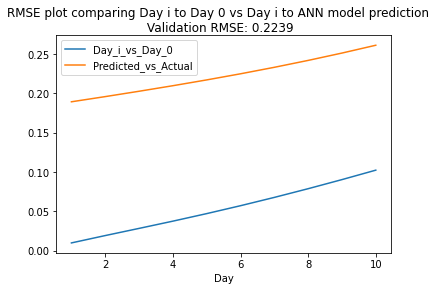

In [81]:
model = get_model(len(w_parms), 100, 100, 100)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
# Model run
history1 = model.fit(
    X_train,
    Y_train,
    epochs=20,
    verbose=0,
    validation_data=(X_val, Y_val),
    callbacks=[],
    batch_size=1000,
)
val_pred = model.predict(X_val)
# Save model to h5 format
tf.keras.models.save_model(
    model, filepath= CONSTANTS["modelh5"], save_format="h5", overwrite=True
)

# visualize model error as function of forecast days
err_pred = Y_val[:, :, 0] - val_pred[:, :, 0]
err_base = -Y_val[:, :, 0] + X_val[0][:, -1, 0][:, np.newaxis]
df_err_mn = pd.DataFrame(
    {
        "Day_i_vs_Day_0": np.sqrt(np.mean(err_base ** 2, axis=0)),
        "Predicted_vs_Actual": np.sqrt(np.mean(err_pred ** 2, axis=0)),
        "Day": 1 + np.arange(CONSTANTS["output_days"]),
    }
).set_index(["Day"])
df_err_mn.plot()
plt.suptitle(
    "RMSE plot comparing Day i to Day 0 vs Day i to ANN model prediction\n Validation RMSE: "
    + str(np.round(np.sqrt(history1.history["val_mse"][-1]), 4))
)
plt.savefig(CONSTANTS["model_result_png"])